# Introduction
The GART (Gaussian Articulated Template Model) is a new way to create 3D models of moving objects, such as people or animals, from simple video recordings. This report documents the steps taken to reproduce Table 2 and Table 3 from the GART paper. The goal is to set up the environment, run the experiments, and verify if the results match. GART is a method that improves 3D reconstruction by using 3D Gaussians and template-based deformation, achieving high-quality and fast rendering. We set up the environment on NHR@FAU HPC (TinyGPU cluster), ran the experiments, and recorded the results.

# Objective of Reproducibility

The goal of this reproducibility study is to verify that we can recreate the results from the GART paper using the provided code and dataset. Specifically, we aim to:

* Set up the computational environment on the HPC system (NHR@FAU).
* Run the experiments to reproduce the results in Table 2 and Table 3.
* Compare our output to the reported results.
* Document any challenges faced during the setup and execution.

Tables 2 and 3 in the paper contain quantitative comparisons between GART and other methods for different datasets. 

These tables evaluate performance based on:

* PSNR (Peak Signal-to-Noise Ratio): Measures how close the generated images are to the real ones.
* SSIM (Structural Similarity Index): Measures how well the structure of the image is preserved.
* LPIPS (Learned Perceptual Image Patch Similarity): Measures perceptual similarity between images (lower is better).

## Set up the computational environment on the HPC system (NHR@FAU).

In [1]:
!git clone https://github.com/MasseyGhalayani/GART

fatal: destination path 'GART' already exists and is not an empty directory.


In [53]:
cd GART/

/home/hpc/mrrr/mrrr120v/GART


In [16]:
!git pull origin main

From https://github.com/MasseyGhalayani/GART
 * branch            main       -> FETCH_HEAD
Already up to date.


### All the commits (changes) to the forked repo for reproduction
the install.sh was resulting in a lot of errors that were explained in detail in the problems at the end of this report.

In [22]:
!git log --author=mrrr120v --oneline --reverse

53223d7 numpy initialization at first.
0012a63 comment out dog config.
a8500a2 make requirements.txt for future.
4d59aa2 make a job script to push a job to slurm
0d2af37 modify the install.sh to work on HPC.
06946a9 make env.yml so it can be recreated.
f7205ee [update] job_script.sh to do all the fitting and eval.
7d2f08b (HEAD -> main, origin/main, origin/HEAD) [add] make a script to download data and put it in a right place.


In [5]:
!cat install.sh

conda create -n gart python=3.9 -y

source activate gart

which python
which pip


module load cuda/11.8
export TORCH_CUDA_ARCH_LIST="7.0;7.5;8.0"

conda install pytorch==2.0.0 torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia -y

# FORCE_CUDA=1 pip install "git+https://github.com/facebookresearch/pytorch3d.git" #
conda install -c fvcore -c iopath -c conda-forge fvcore iopath -y
conda install pytorch3d -c pytorch3d -y

pip install -r requirements.txt

pip install lib_render/simple-knn
pip install lib_render/diff_gaussian_rasterization-alphadep
# git clone https://github.com/bytedance/MVDream lib_guidance/mvdream/extern/MVDream
pip install -e lib_guidance/mvdream/extern/MVDream

# cd lib_marchingcubes
# python setup.py build_ext --inplace
# python setup_c.py build_ext --inplace # for kdtree in cuda 11

pip install lpips
# pip install git+https://github.com/NVlabs/tiny-cuda-nn/@v1.6#subdirectory=bindings/torch # Not used in release version

### Installing the modified install.sh
the install.sh was resulting in a lot of errors that were explained in detail in the problems at the end of this report.

In [ ]:
!bash install.sh

In [6]:
!bash data_download.sh

# conda environments:
#
base                     /apps/jupyterhub/jh3.1.1-py3.11
CMRI-24WS                /apps/jupyterhub/jh3.1.1-py3.11/envs/CMRI-24WS
k29t                     /apps/jupyterhub/jh3.1.1-py3.11/envs/k29t
python3_9                /apps/jupyterhub/jh3.1.1-py3.11/envs/python3_9
pytorch-1.13.1           /apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-1.13.1
pytorch-2.0.1            /apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-2.0.1
pytorch-2.1.0            /apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-2.1.0
pytorch-2.2.0            /apps/jupyterhub/jh3.1.1-py3.11/envs/pytorch-2.2.0
rstudio                  /apps/jupyterhub/jh3.1.1-py3.11/envs/rstudio
tensorflow-2.12.1        /apps/jupyterhub/jh3.1.1-py3.11/envs/tensorflow-2.12.1
tensorflow-2.14.0        /apps/jupyterhub/jh3.1.1-py3.11/envs/tensorflow-2.14.0
tensorflow-2.15.0        /apps/jupyterhub/jh3.1.1-py3.11/envs/tensorflow-2.15.0
gart                     /home/hpc/mrrr/mrrr120v/.conda/envs/gart



## Run the script for people30s and ubc_fashion dataset. Table 2 and Table 3

In [56]:
!cat job_script.sh

7897.77s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
#!/bin/bash -l
#
#SBATCH --job-name=solver_job         # A descriptive name for your job
#SBATCH --output=job_%j.out            # Standard output will be saved to job_<jobID>.out
#SBATCH --error=job_%j.err             # Standard error will be saved to job_<jobID>.err
#SBATCH --gres=gpu:rtx3080:1              # Request 1 rtx3080 GPU (adjust if needed)
#SBATCH --partition=rtx3080               # Use the rtx3080 partition (change to e.g., a100 or work as appropriate)
#SBATCH --time=6:00:00                 # Set maximum walltime to 6 hours
#SBATCH --export=NONE                  # Do not propagate your current environment

# Unset exported environment variables from the submission environment (if needed)
unset SLURM_EXPORT_ENV

# Load necessary modules (for example, the Python module that provides conda)
module load cuda/11.8

# Activate your conda environment (replace 'gart' with your actual envi

In [ ]:
!bash job_script.sh

### Get the result from the logs Table2

In [10]:
pwd

'/home/hpc/mrrr/mrrr120v'

In [25]:
import os
import re
import pandas as pd  

base_path = "GART/logs/people_30s"
results = []

# Define expected sequences from Table 2
expected_sequences = ["=female-3-casual", "=female-4-casual", "=male-3-casual", "=male-4-casual"]

for root, dirs, files in os.walk(base_path):
    for file in files:
        if file == "results_test_tto_evaluator_instant-avatar.txt":
            for seq in expected_sequences:
                if seq in root:  # Match sequence name in directory path
                    file_path = os.path.join(root, file)

                    with open(file_path, "r") as f:
                        content = f.read()

                    psnr = re.search(r"\[test_tto\] PSNR: ([\d.]+)", content)
                    ssim = re.search(r"\[test_tto\] SSIM: ([\d.]+)", content)
                    lpips = re.search(r"\[test_tto\] LPIPS: ([\d.]+)", content)

                    if psnr and ssim and lpips:
                        results.append({
                            "Sequence": seq,
                            "PSNR Reproduced": float(psnr.group(1)),
                            "SSIM Reproduced": float(ssim.group(1)),
                            "LPIPS Reproduced": float(lpips.group(1))
                        })

df_reproduced = pd.DataFrame(results)

# Reported values from Table 2
df_reported = pd.DataFrame({
    "Sequence": expected_sequences,
    "PSNR Reported": [26.26, 29.23, 30.40, 27.57],
    "SSIM Reported": [0.9656, 0.9720, 0.9769, 0.9657],
    "LPIPS Reported": [0.0498, 0.0378, 0.0377, 0.0607]
})



In [26]:
df_comparison = df_reported.merge(df_reproduced, on="Sequence", how="left")
df_comparison

,Sequence,PSNR Reported,SSIM Reported,LPIPS Reported,PSNR Reproduced,SSIM Reproduced,LPIPS Reproduced
0,=female-3-casual,26.26,0.9656,0.0498,26.29,0.9668,0.0495
1,=female-4-casual,29.23,0.9720,0.0378,29.24,0.9730,0.0386
2,=male-3-casual,30.40,0.9769,0.0377,30.37,0.9777,0.0380
3,=male-4-casual,27.57,0.9657,0.0607,27.58,0.9670,0.0605


### Get the result from the logs Table3

In [40]:
import os
import re
import pandas as pd
import numpy as np

base_path = "GART/logs/ubc_mlp"
results = []

for root, dirs, files in os.walk(base_path):
    for file in files:
        if file == "results_test_tto_evaluator_instant-avatar.txt":
            file_path = os.path.join(root, file)

            with open(file_path, "r") as f:
                content = f.read()

            psnr = re.search(r"\[test_tto\] PSNR: ([\d.]+)", content)
            ssim = re.search(r"\[test_tto\] SSIM: ([\d.]+)", content)
            lpips = re.search(r"\[test_tto\] LPIPS: ([\d.]+)", content)

            if psnr and ssim and lpips:
                results.append({
                    "PSNR": float(psnr.group(1)),
                    "SSIM": float(ssim.group(1)),
                    "LPIPS": float(lpips.group(1))
                })

df_reproduced = pd.DataFrame(results)

if not df_reproduced.empty:
    avg_psnr = np.mean(df_reproduced["PSNR"])
    avg_ssim = np.mean(df_reproduced["SSIM"])
    avg_lpips = np.mean(df_reproduced["LPIPS"])
else:
    avg_psnr, avg_ssim, avg_lpips = None, None, None  # Handle empty results

df_avg_reproduced = pd.DataFrame({
    "Method": ["GART T-Table (Avg of six seq)"],
    "PSNR": [avg_psnr],
    "SSIM": [avg_ssim],
    "LPIPS": [avg_lpips*1000]
})

df_reported = pd.DataFrame({
    "Method": ["GART T-Table (paper)"],
    "PSNR": [25.96],
    "SSIM": [0.935],
    "LPIPS": [80.57]
})




In [42]:
df_comparison = pd.concat([df_reported, df_avg_reproduced], ignore_index=True)
df_comparison

,Method,PSNR,SSIM,LPIPS
0,GART T-Table (paper),25.960,0.935000,80.57
1,GART T-Table (Avg of six seq),25.615,0.935267,82.25


### Reproduced images in Figure5 

In [51]:
from PIL import Image, ImageOps
import math

base_path = "GART/logs/ubc_mlp"
output_path = os.path.join("GART", "collage.png")

selected_images = []

for root, dirs, files in os.walk(base_path):
    if "test_tto" in root:
        image_files = sorted([f for f in files if f.endswith(".png")])
        if image_files:
            selected_images.append(os.path.join(root, image_files[0]))

images = [Image.open(img) for img in selected_images[:6]] 

cols, rows = 2, 3
thumb_width, thumb_height = max(img.size[0] for img in images), max(img.size[1] for img in images)

collage_width = cols * thumb_width
collage_height = rows * thumb_height

collage = Image.new("RGB", (collage_width, collage_height), (255, 255, 255))

for idx, img in enumerate(images):
    x_offset = (idx % cols) * thumb_width
    y_offset = (idx // cols) * thumb_height
    collage.paste(ImageOps.fit(img, (thumb_width, thumb_height)), (x_offset, y_offset))

collage.save(output_path)

print(f"Collage saved at: {output_path}")


Collage saved at: GART/collage.png


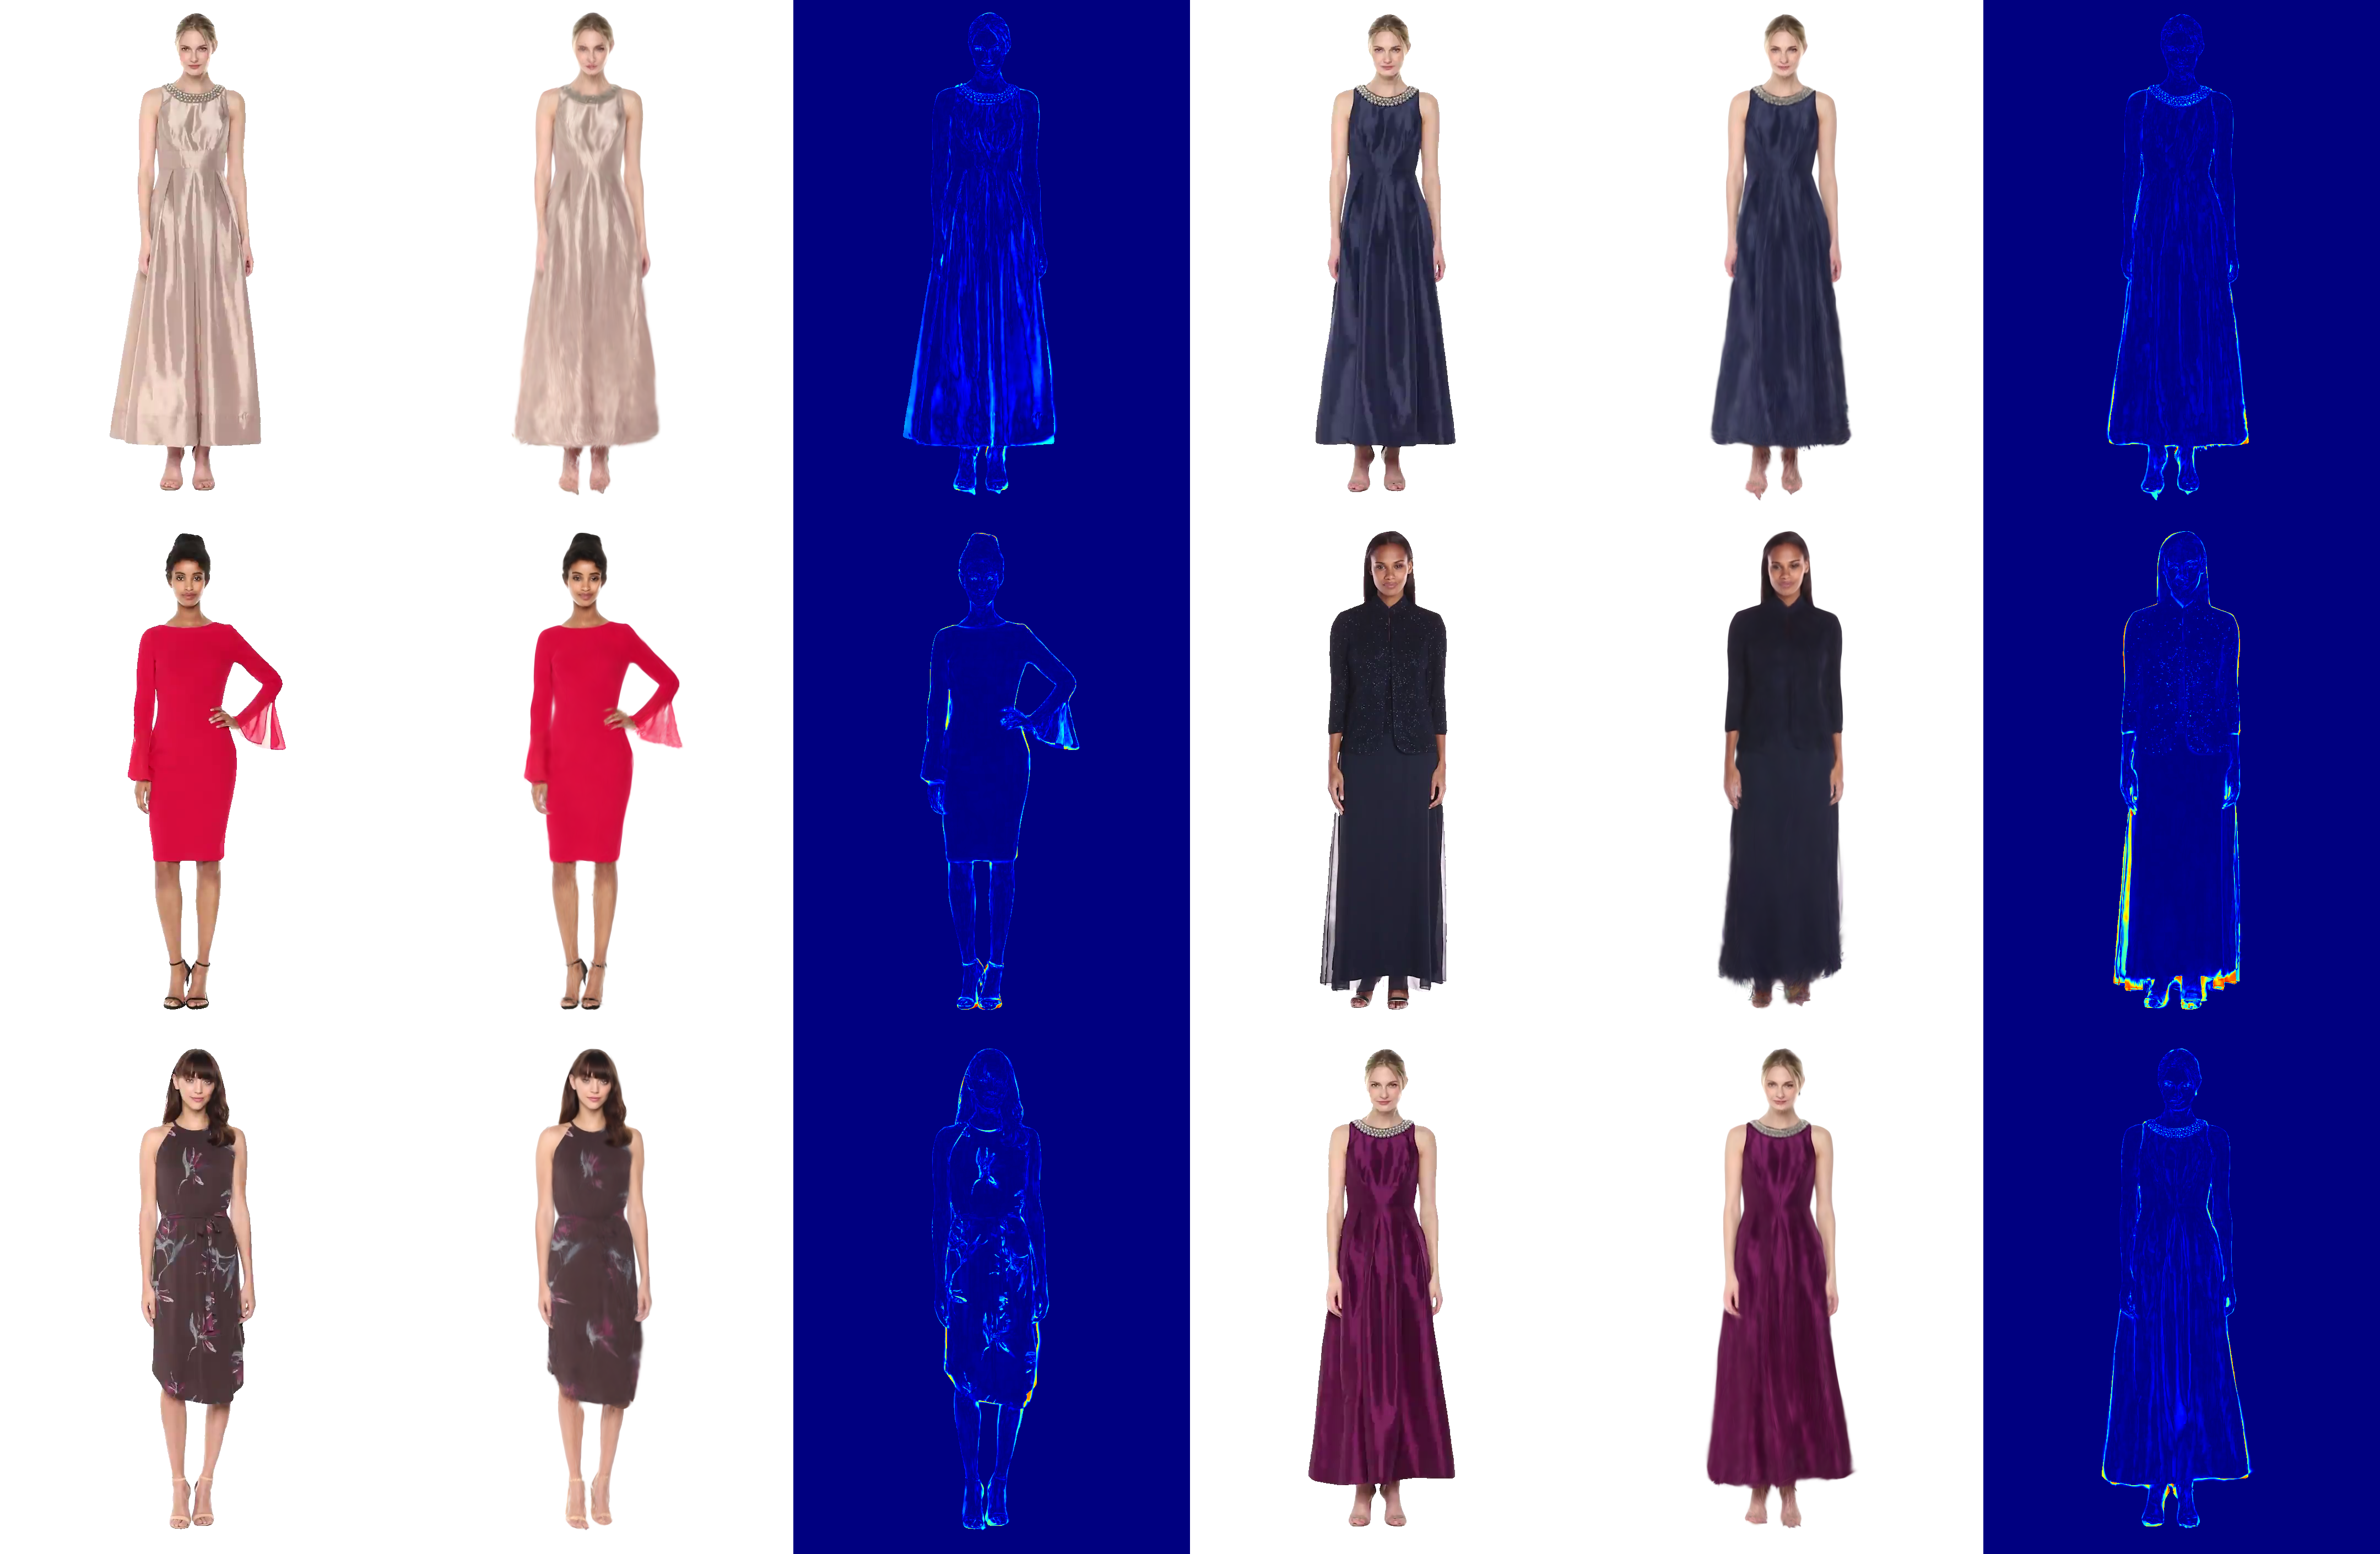

In [50]:
import IPython.display as display
display.display(display.Image(filename="GART/collage.png",width=800, height=600))

# The Challanges and the way to fix it.

## NumPy Multiarray Import Error

## 2. Encountered Errors and Debugging Steps
This section documents the errors encountered during the setup and execution, along with the debugging steps taken to resolve them.

### 2.1. NumPy Multiarray Import Error
**Error Message:**
```
ImportError: numpy._core.multiarray failed to import
```
**Solution:**
- Ensured NumPy was preloaded before importing OpenCV.
- Reinstalled all the dependencies that they have confilict with numpy 1.23.1.
- Eventually degrade numpy to 1.23.0


### 2.2. CUDA Version Mismatch
**Error Message:**
```
RuntimeError: The detected CUDA version (11.8) mismatches the version used to compile PyTorch (12.6)
```
**Solution:**
- Loaded the correct CUDA module: `module load cuda/11.8`.


### 2.3. PyTorch3D Undefined Symbol Error
**Error Message:**
```
ImportError: /home/.../pytorch3d/_C.cpython-39-x86_64-linux-gnu.so: undefined symbol: _ZNK3c105Error4whatEv
```
**Solution:**
- Set CUDA architecture: `export TORCH_CUDA_ARCH_LIST="7.0;7.5;8.0"`.
- Reinstalled **PyTorch3D** matching the PyTorch version.
- Downgraded PyTorch or compiled PyTorch3D from source.


### 2.4. NVIDIA Driver Not Found Error
**Error Message:**
```
RuntimeError: Found no NVIDIA driver on your system.
```
**Solution:**
- Ensured GPU was available using `nvidia-smi`.
- Used **Slurm** to correctly allocate a **GPU-enabled node**.


### 2.5. Building `simple-knn` Extension Error
**Error Message:**
```
RuntimeError: The detected CUDA version (11.8) mismatches the version that was used to compile PyTorch (12.6)
IndexError: list index out of range
```
**Solution:**
- Loaded the appropriate CUDA module (`module load cuda/12.6.1`).
- Explicitly set CUDA architecture:
  ```bash
  export TORCH_CUDA_ARCH_LIST="7.0;7.5;8.0"
  ```
- Installed `ninja` to speed up the build process:
  ```bash
  pip install ninja
  ```